## Movie Data Set Notebook #1 -- General Preprocessing

In [109]:
# General imports here.
import pandas as pd
import numpy as np
import sklearn as sk
import math
import ast
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
# Read the csv files and index appropriately.
keywords_df = pd.read_csv('./data/keywords.csv')
credits_df = pd.read_csv('./data/credits.csv')
metadata_df = pd.read_csv('./data/movies_metadata.csv')

In [111]:
# These three files seem to be the ones we want. Indexed on ID, we could probably combine them now.
keywords_df = keywords_df.set_index('id')
credits_df = credits_df.set_index('id')
metadata_df = metadata_df.set_index('id')
None

In [112]:
# Join the useful data frames together
temp = keywords_df.join(credits_df)
movie_df = metadata_df.join(temp)

In [113]:
# Here I'm just doing some of the same stuff "The Story of Film" did on Kaggle.
# This all makes sense, it's pretty standard.
movie_df = movie_df.drop(['imdb_id'], axis=1)
movie_df = movie_df.drop(['original_title'], axis=1)
movie_df = movie_df.drop(['video'], axis=1)
base_poster_url = 'http://image.tmdb.org/t/p/w185'
#movie_df['poster_path'] = "<img src='" + base_poster_url + movie_df['poster_path'] + "' style='height:100px;'>"
movie_df['poster_path'] = base_poster_url + movie_df['poster_path']

In [114]:
# Clean up from https://www.kaggle.com/hadasik/movies-analysis-visualization-newbie
def get_values(data_str):
    if isinstance(data_str, float):
        pass
    else:
        values = []
        data_str = ast.literal_eval(data_str)
        if isinstance(data_str, list):
            for k_v in data_str:
                values.append(k_v['name'])
            return values
        else:
            return None

In [115]:
movie_df[['genres']] = movie_df[['genres']].applymap(get_values)
movie_df[['production_companies', 'production_countries']] = movie_df[['production_companies', 'production_countries']].applymap(get_values)
movie_df[['spoken_languages', 'keywords']] = movie_df[['spoken_languages', 'keywords']].applymap(get_values)
movie_df[['cast', 'crew']] = movie_df[['cast', 'crew']].applymap(get_values)
# This takes a while to run.
# Also, it gets rid of character data and position in the crew. We may want that information.

In [116]:
# Make the Collection feature readable. The previously defined function doesn't seem to work for this feature.
temp = movie_df[movie_df['belongs_to_collection'].notnull()]
temp = temp['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
for index in temp.index:
    movie_df.loc[index, 'belongs_to_collection'] = temp.loc[index]
movie_df['belongs_to_collection'].fillna(0, inplace=True)

In [117]:
# I took care of some of the NaN values already.
movie_df = movie_df[pd.notnull(movie_df['title'])]
movie_df = movie_df[pd.notnull(movie_df['keywords'])]
movie_df = movie_df[pd.notnull(movie_df['original_language'])]
movie_df = movie_df[pd.notnull(movie_df['status'])]
movie_df = movie_df[pd.notnull(movie_df['release_date'])]
movie_df = movie_df[pd.notnull(movie_df['poster_path'])]
movie_df = movie_df[pd.notnull(movie_df['overview'])]
movie_df = movie_df[pd.notnull(movie_df['runtime'])]

In [118]:
# Make the homepage feature a binary variable since we don't care what the URL is.
movie_df['homepage'].fillna(0, inplace=True)
movie_df.loc[movie_df['homepage'] != 0, 'homepage'] = 1
movie_df['homepage'] = movie_df['homepage'].astype(np.int64)

In [119]:
# Replace tagline NaNs
movie_df['tagline'].fillna(0, inplace=True)
# Drop status when not released.
movie_df = movie_df.loc[movie_df['status'] == 'Released']
movie_df = movie_df.drop(['status'], axis = 1)

In [120]:
# Check for NaNs. None, that's good.
print(movie_df.isnull().any())

belongs_to_collection    False
budget                   False
genres                   False
homepage                 False
original_language        False
overview                 False
poster_path              False
production_companies     False
production_countries     False
release_date             False
revenue                  False
runtime                  False
spoken_languages         False
tagline                  False
title                    False
vote_average             False
vote_count               False
keywords                 False
cast                     False
crew                     False
dtype: bool


In [121]:
# belongs_to_collection: Similar to tagline, we may just want a binary variable
# tagline: Until we actually analyze the taglines, I think we should just replace with a tag_presence binary variable
# revenue and budget are both missing a lot of data, we'll have to deal with that.
movie_df.head().transpose()

id,2,3,5,6,11
belongs_to_collection,0,0,0,0,Star Wars Collection
budget,0,0,4000000,0,11000000
genres,"[Drama, Crime]","[Drama, Comedy]","[Crime, Comedy]","[Action, Thriller, Crime]","[Adventure, Action, Science Fiction]"
homepage,0,0,0,0,1
original_language,fi,fi,en,en,en
overview,Taisto Kasurinen is a Finnish coal miner whose...,"An episode in the life of Nikander, a garbage ...",It's Ted the Bellhop's first night on the job....,"While racing to a boxing match, Frank, Mike, J...",Princess Leia is captured and held hostage by ...
poster_path,http://image.tmdb.org/t/p/w185/gZCJZOn4l0Zj5hA...,http://image.tmdb.org/t/p/w185/7ad4iku8cYBuB08...,http://image.tmdb.org/t/p/w185/eQs5hh9rxrk1m4x...,http://image.tmdb.org/t/p/w185/lNXmgUrP6h1nD53...,http://image.tmdb.org/t/p/w185/btTdmkgIvOi0FFi...
production_companies,"[Villealfa Filmproduction Oy, Finnish Film Fou...",[Villealfa Filmproduction Oy],"[Miramax Films, A Band Apart]","[Universal Pictures, Largo Entertainment, JVC ...","[Lucasfilm, Twentieth Century Fox Film Corpora..."
production_countries,[Finland],[Finland],[United States of America],"[Japan, United States of America]",[United States of America]
release_date,10/21/1988,10/16/1986,12/9/1995,10/15/1993,5/25/1977


In [122]:
movie_df.describe()

,budget,homepage,revenue,runtime,vote_average,vote_count
count,4.480900e+04,44809.000000,4.480900e+04,44809.000000,44809.000000,44809.000000
mean,4.326793e+06,0.175991,1.147099e+07,95.436586,5.670048,112.253186
std,1.760014e+07,0.380817,6.504556e+07,37.242841,1.850511,495.731625
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,86.000000,5.000000,3.000000
50%,0.000000e+00,0.000000,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,0.000000,0.000000e+00,107.000000,6.800000,36.000000
max,3.800000e+08,1.000000,2.787965e+09,1256.000000,10.000000,14075.000000


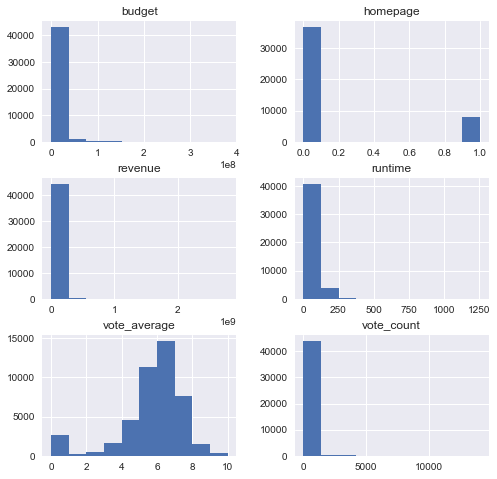

In [123]:
_ = movie_df.hist(figsize=(8,8))

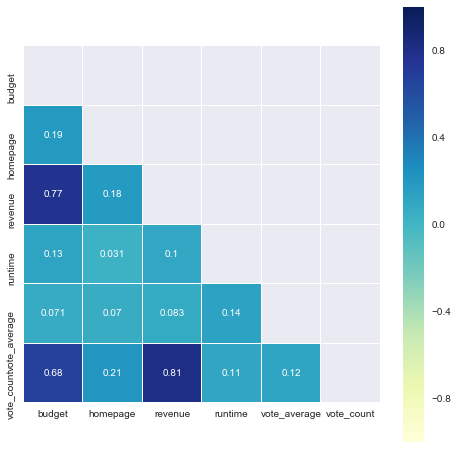

In [124]:
# A quick heatmap. It seems revenue and the number of votes are correlated.
corr = movie_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 8))
_ = sns.heatmap(corr, vmax=1, vmin=-1, mask=mask, square=True, annot=True, linewidths=0.2, center=0, cmap="YlGnBu")

In [125]:
# Toy Story Entry Example, looking it up by ID number
print(movie_df.loc[862])

belongs_to_collection                                 Toy Story Collection
budget                                                            30000000
genres                                         [Animation, Comedy, Family]
homepage                                                                 1
original_language                                                       en
overview                 Led by Woody, Andy's toys live happily in his ...
poster_path              http://image.tmdb.org/t/p/w185/rhIRbceoE9lR4ve...
production_companies                             [Pixar Animation Studios]
production_countries                            [United States of America]
release_date                                                    10/30/1995
revenue                                                        3.73554e+08
runtime                                                                 81
spoken_languages                                                 [English]
tagline                  

In [126]:
# You can't use the partially displayed link above.
print(movie_df.loc[862, 'poster_path'])

http://image.tmdb.org/t/p/w185/rhIRbceoE9lR4veEXuwCC2wARtG.jpg


### Actors

In [127]:
print movie_df.shape
movie_df_mod = movie_df.loc[movie_df['revenue'] != 0]
movie_df_mod = movie_df_mod.loc[movie_df_mod['budget'] != 0]
print movie_df_mod.shape
movie_df_mod['revenue'] = movie_df_mod['revenue'].apply(lambda x: x if x > 100 else x*1000000)
movie_df_mod['revenue'] = movie_df_mod['revenue'].apply(lambda x: x if (x > 999) else x*1000)
movie_df_mod['budget'] = movie_df_mod['budget'].apply(lambda x: x if x > 100 else x*1000000)
movie_df_mod['budget'] = movie_df_mod['budget'].apply(lambda x: x if (x > 999) else x*1000)

(44809, 20)
(5443, 20)


In [128]:
actors_df = pd.read_csv('./data/actors.csv')
actors_df = actors_df.set_index('actors')

# way to parse through all the movie lists of actors and crew to find average revenue for each
"""crew_mem = []
num_movies = []
revenue_avg = []
counter = 0
for index, row in movie_df.iterrows():
    crew = row['crew']
    revenue = row['revenue']
    if(counter%1000 == 0):
        print(counter)
    counter += 1
    for person in crew:
        try:
            index = crew_mem.index(person)
        except:
            index = -1
        if(index != -1):
            temp = revenue_avg[index] * num_movies[index]
            temp += revenue
            num_movies[index] += 1
            revenue_avg[index] = temp/num_movies[index]
        else:
            crew_mem.append(person)
            num_movies.append(1)
            revenue_avg.append(revenue)"""
None

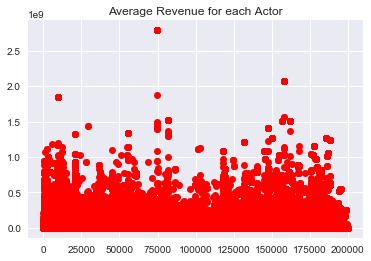

In [129]:
actors_df = pd.read_csv('./data/actors.csv')
actors_df = actors_df.set_index('actors')
x = []
for i in range(0,actors_df.shape[0]):
    x.append(i)
rev = actors_df['average_revenue']
mov = actors_df['number_of_movies']
rev_sh = actors_df['average_revenue (shifted)']
plt.plot(x,rev, 'ro')
plt.title("Average Revenue for each Actor")
plt.show()

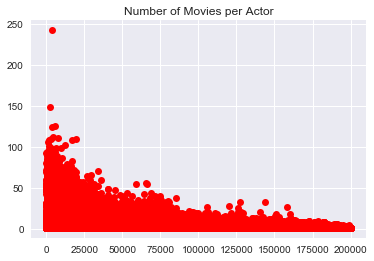

In [130]:
plt.plot(x,mov, 'ro')
plt.title("Number of Movies per Actor")
plt.show()

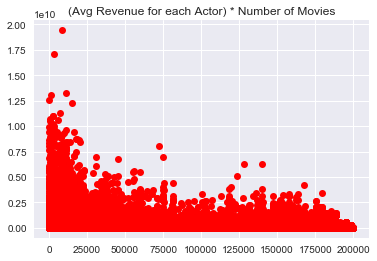

In [131]:
plt.plot(x,rev_sh, 'ro')
plt.title("(Avg Revenue for each Actor) * Number of Movies")
plt.show()

In [132]:
actor = actors_df['average_revenue'].argmax()
actor2 = actors_df['number_of_movies'].argmax()
actor3 = actors_df['average_revenue (shifted)'].argmax()
print ("Largest Average Revenue:")
print("Actor: " + actor + "  Num_Movies: " + str(actors_df.loc[actor,'number_of_movies']) + "  Avg_Revenue: " + str(actors_df.loc[actor,'average_revenue']) + "\n")
print ("Most Movies:")
print("Actor: " + actor2 + "  Num_Movies: " + str(actors_df.loc[actor2,'number_of_movies']) + "  Avg_Revenue: " + str(actors_df.loc[actor2,'average_revenue']) + "\n")
print ("Largest Average Shifted Revenue:")
print("Actor: " + actor3 + "  Num_Movies: " + str(actors_df.loc[actor3,'number_of_movies']) + "  Avg_Revenue: " + str(actors_df.loc[actor3,'average_revenue']) + "\n")

Largest Average Revenue:
Actor: Sean Anthony Moran  Num_Movies: 1.0  Avg_Revenue: 2787965087.0

Most Movies:
Actor: Bess Flowers  Num_Movies: 242.0  Avg_Revenue: 1524434.955

Largest Average Shifted Revenue:
Actor: Stan Lee  Num_Movies: 49.0  Avg_Revenue: 396223623.6



In [133]:
def to_file(filename, crew, num_mov, avg_rev):
    with open(filename, 'w') as f:
        f.write('crew,number_of_movies,average_revenue\n')
        for cre, mov, rev in zip(crew, num_mov, avg_rev):
            f.write('{},{},{}\n'.format(cre, mov, rev))

In [134]:
# We could only do movies where the original language is English.
movie_df.loc[movie_df['original_language'] == 'en'].shape

(32199, 20)

### Posters

In [135]:
from PIL import Image

# Taken from https://zeevgilovitz.com/detecting-dominant-colours-in-python
def compare(title, image, colour_tuple):
    #image.show(title=title)
    image = Image.new("RGB", (200, 200,), colour_tuple)
    return image

def most_frequent_colour(image):

    w, h = image.size
    pixels = image.getcolors(w * h)

    most_frequent_pixel = pixels[0]

    for count, colour in pixels:
        if count > most_frequent_pixel[0]:
            most_frequent_pixel = (count, colour)

    imshow(compare("Most Common", image, most_frequent_pixel[1]))

    return most_frequent_pixel

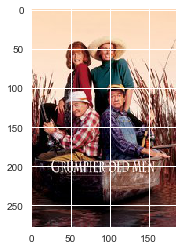

In [136]:
import requests
from io import BytesIO
from matplotlib.pyplot import imshow

# Get Toy Story Poster Image
response = requests.get(movie_df.loc[15602]['poster_path'])
img = Image.open(BytesIO(response.content))
imshow(img)

(613, (252, 219, 188))

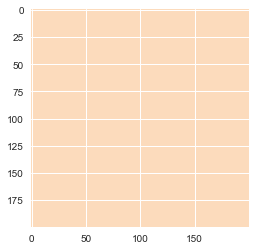

In [137]:
most_frequent_colour(img)